# Supervised Learning Algorithms
In this notebook, several supervised learning algorithms are used to create binary classifiers that distinguish between benign and malicious traffics in the ids-2017 dataset. Hyperparameters are optimized to obtain a model with the best results and the models are compared

In [1]:
from notebook_utils import load_processed_dataset_2017, plot_confusion_matrix, metrics_report, upsample_dataset, extract_and_plot_metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, average_precision_score, make_scorer, precision_score, accuracy_score, confusion_matrix
from notebook_utils import upsample_dataset
%matplotlib inline
%load_ext autoreload
%autoreload 2
file_path = r"CIC-IDS-2017\CSVs\GeneratedLabelledFlows\TrafficLabelling\processed\ids2017_processed.csv"

In [2]:
X_train, Y_train, X_eval, Y_eval, X_test, Y_test, scaler = load_processed_dataset_2017(file_path)

In [3]:
performance_models = {}

In [4]:
import joblib

def save_model(model, model_name):
    file_path = f'models/{model_name}.pkl'
    joblib.dump(model, file_path)
    print(f'Model saved to {file_path}')

def load_model(model_name):
    file_path = f'models/{model_name}.pkl'
    model = joblib.load(file_path)
    print(f'Model loaded from {file_path}')
    return model

os.makedirs('models', exist_ok=True)

## 1. Naive Bayes

In [5]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
# Fit the model on the training data
nb_model.fit(scaler.transform(X_train), Y_train.is_attack)

GaussianNB()

Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9992    0.4419    0.6127    227310
           1     0.3050    0.9985    0.4673     55764

    accuracy                         0.5515    283074
   macro avg     0.6521    0.7202    0.5400    283074
weighted avg     0.8624    0.5515    0.5841    283074

Accuracy: 0.551502433992525
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9992    0.4442    0.6150    227310
           1     0.3059    0.9986    0.4684     55765

    accuracy                         0.5534    283075
   macro avg     0.6526    0.7214    0.5417    283075
weighted avg     0.8626    0.5534    0.5862    283075

Accuracy: 0.5534469663516736


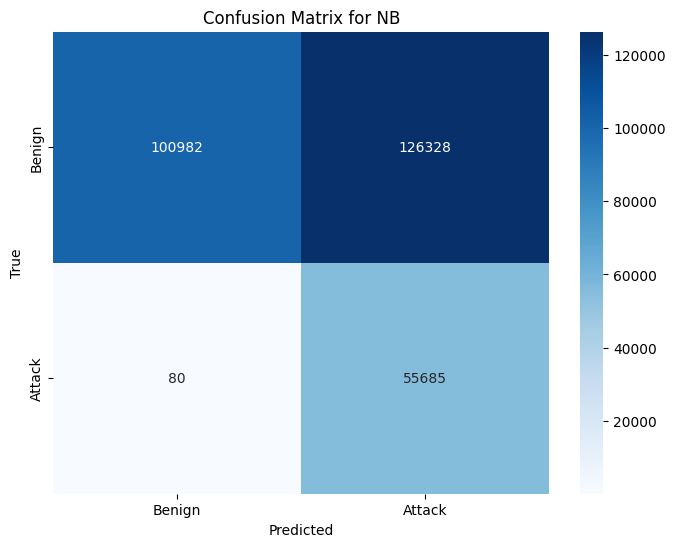

In [6]:
# Predict and evaluate on the evaluation set
y_pred_eval = nb_model.predict(scaler.transform(X_eval))
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test = nb_model.predict(scaler.transform(X_test))
performance_models["NB"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("NB", Y_test, y_pred_test)

In [7]:
save_model(nb_model, 'nb_model')

Model saved to models/nb_model.pkl


## 2. K-Nearest Neighbors (KNN)

Evaluation Set Performance
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9739    0.9986    0.9861    227310
           1     0.9936    0.8910    0.9395     55764

    accuracy                         0.9774    283074
   macro avg     0.9837    0.9448    0.9628    283074
weighted avg     0.9778    0.9774    0.9769    283074

Accuracy: 0.977391070886058
Test Set Performance
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9736    0.9988    0.9860    227310
           1     0.9943    0.8896    0.9390     55765

    accuracy                         0.9772    283075
   macro avg     0.9840    0.9442    0.9625    283075
weighted avg     0.9777    0.9772    0.9768    283075

Accuracy: 0.9772498454473196


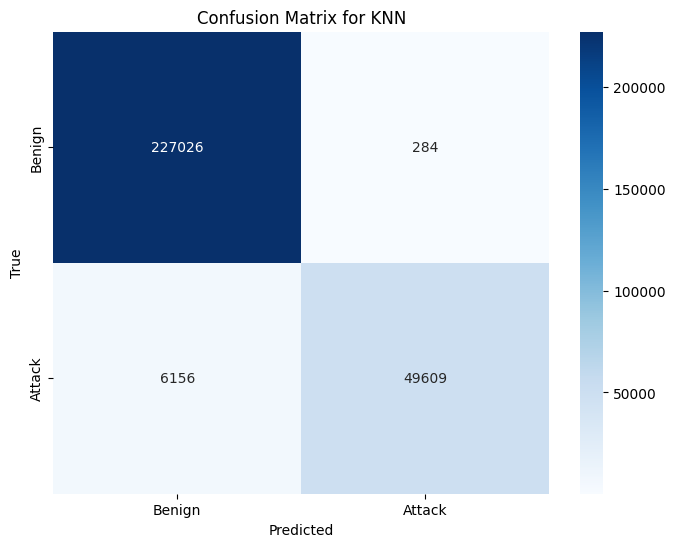

Model saved to models/knn_model.pkl


In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(scaler.transform(X_train), Y_train.is_attack)

# Predict and evaluate on the evaluation set
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.is_attack, knn_model.predict(scaler.transform(X_eval)), print_avg=False)

# Predict and evaluate on the test set
print("Test Set Performance")
Y_pred = knn_model.predict(scaler.transform(X_test))
performance_models["KNN"] = metrics_report("Test", Y_test.is_attack, Y_pred, print_avg=False)
plot_confusion_matrix("KNN", Y_test, Y_pred)

save_model(knn_model, 'knn_model')

## 3. Quadratic Discriminant Analysis (QDA)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(scaler.transform(X_train))
X_eval_pca = pca.transform(scaler.transform(X_eval))
X_test_pca = pca.transform(scaler.transform(X_test))

# Define the parameter grid for RandomizedSearchCV
param_grid_qda = {
    'reg_param': [0.0, 0.1, 0.5, 1.0],
    'store_covariance': [True, False],
    'tol': [1e-4, 1e-3, 1e-2]
}

# Initialize the QDA Classifier
qda_model = QuadraticDiscriminantAnalysis()

# Initialize RandomizedSearchCV
random_search_qda = RandomizedSearchCV(estimator=qda_model, param_distributions=param_grid_qda, n_iter=10,
                                       scoring='accuracy', n_jobs=-1, cv=2, verbose=2, random_state=42)

# Fit the model on the PCA-transformed training data
random_search_qda.fit(X_train_pca, Y_train.is_attack)

# Get the best model
best_qda_model = random_search_qda.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters for QDA:", random_search_qda.best_params_)

# Save the best model
save_model(best_qda_model, 'qda_model')

# Predict and evaluate on the evaluation set
print("Evaluation Set Performance")
metrics_report("Evaluation", Y_eval.is_attack, best_qda_model.predict(X_eval_pca), print_avg=False)

# Predict and evaluate on the test set
print("Test Set Performance")
Y_pred = best_qda_model.predict(X_test_pca)
performance_models["QDA"] = metrics_report("Test", Y_test.is_attack, Y_pred, print_avg=False)
plot_confusion_matrix("QDA", Y_test, Y_pred)


In [ ]:
# Predict and evaluate on the evaluation set
y_pred_eval_qda = best_qda_model.predict(scaler.transform(X_eval))
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval_qda, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_qda = best_qda_model.predict(scaler.transform(X_test))
performance_models["QDA"] = metrics_report("Test", Y_test.is_attack, y_pred_test_qda, print_avg=False)
plot_confusion_matrix("QDA", Y_test.is_attack, y_pred_test_qda)

## 4. Support Vector Machine

The SVM takes too long with the number of features and number of training examples. PCA components are used to reduce the number of features. 

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
import joblib
import os

# Apply PCA to reduce the number of features
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_eval_pca = pca.transform(X_eval)
X_test_pca = pca.transform(X_test)

# Define the LinearSVC model with chosen hyperparameters
linear_svc_model = LinearSVC(C=1, max_iter=10000, dual="auto")

# Fit the model on the training data
linear_svc_model.fit(X_train_pca, Y_train.is_attack)

# Save the model
save_model(linear_svc_model, 'linear_svc_binary_pca')

# Evaluate the model
# Predict on the evaluation set
y_pred_eval = linear_svc_model.predict(X_eval_pca)
performance_eval = metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test = linear_svc_model.predict(X_test_pca)
performance_models["LinearSVC"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)

# Plot the confusion matrix
plot_confusion_matrix("LinearSVC", Y_test, y_pred_test)

## 5. Conclusion

In [ ]:
extract_and_plot_metrics(performance_models)